# Data Science for Good - Jobs in LA

### Goal
In 2020, 1/3 of the 50000 employees of the City of Los Angeles will retire. The goal of this project is to uncover biases in job postings provided by the city of L.A to help optimize recruitment and decrease unconscious discriminations.

### Entry Data
The entry data is composed of a set of 683 job postings as text files. Each file is composed of a title, the job descrription, the requirements, the selection methods, the deadline to apply and other parts that we are going to explore.

### Action plan
We'll be performing the following actions :
1. Exploratory Data Analysis
2. Uncover gender bias
> Requirements length : studies show the length of requirements can discourage women from applying

3. Explore other biases by correlation analysis
> Number of steps in the recruiting process
> Deadline for applying : is it too short ? Do the candidates have time to get aware of the job and prepare to apply ?

4. Listing suspicious Job postings

5. Text analysis
> Word cloud 
> Named Entity Recognition

### 1. Exploratory Data Analysis

In [1]:
# Imports
import os 
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

# for gender biases
#import genderdecoder
import assess

# for text analysis
import nltk
import pickle
import collections
from nltk.corpus import wordnet as wn
from nltk import word_tokenize, pos_tag
from collections import defaultdict, Counter
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wboli\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wboli\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [2]:
# variable definition
path_bulletins = r".\data-science-for-good-city-of-los-angeles\CityofLA\Job Bulletins"
bulletins=os.listdir(path_bulletins)

In [3]:
def days_between(d1, d2):
# computes the duration in days between d2 and d1   
    try:
        d1 = datetime.strptime(d1.strftime("%Y-%m-%d"), "%Y-%m-%d")
        d2 = datetime.strptime(d2.strftime("%Y-%m-%d"), "%Y-%m-%d")
        return abs((d2 - d1).days)
    except:
        return np.nan


def to_dataframe(num, df, locationdir):
# Reads all the files located in locationdir and retreives all interesting field as well as coputing interesting stats.
    """"function to extract features from job bulletin text files and convert to
    pandas dataframe.
    Arguments :
    1.the number of files to be read
    2.dataframe object                                      
    3.directory in which the files are located                        
    """
    opendate=re.compile(r'(Open [D,d]ate:)(\s+)(\d\d-\d\d-\d\d)')       #match open date
    
    salary=re.compile(r'\$(\d+,\d+)((\s(to|and)\s)(\$\d+,\d+))?')       #match salary
    
    requirements=re.compile(r'(REQUIREMENTS?/\s?MINIMUM QUALIFICATIONS?)(.*)(PROCESS NOTE)')      #match requirements
    
    for no in range(0,num):
        nblines = 0
        nbchars = 0
        with open(locationdir+"/" +bulletins[no],encoding="ISO-8859-1") as f:         #reading files 
                try:
                    file=f.read().replace('\t','')
                    nblines = file.count('\n')
                    raw_text=file.replace('\n',' ')
                    data=file.replace('\n','')
                    nbchars = len(data)
                    # print(data)
                    headings=[heading for heading in file.split('\n') if heading.isupper()]             ##getting heading from job bulletin

                    
                    try:
                        sal=re.search(salary,data)
                    except:
                        sal=np.nan
                        #print(bulletins[no])
                        #print("no matching salary")
                    
                    try:
                        odate=datetime.strptime(re.search(opendate,data).group(3),'%m-%d-%y')
                    except:
                        date=np.nan
                        #print(bulletins[no])
                        #print("no matching opendate")
                        
                    try:
                        req=re.search(requirements,data).group(2)
                    except Exception as e:
                        try:
                            req=re.search('(.*)NOTES?',re.findall(r'(REQUIREMENTS?)(.*)(NOTES?)',
                                                              data)[0][1][:1200]).group(1)
                        except:
                            date=np.nan
                            #print(bulletins[no])
                            #print("no matching requirements")
                    
                    duties=re.search(r'(DUTIES)(.*)(REQ[A-Z])',data).group(2)
                    
                        
                    try:
                        enddate=re.search(
                                r'(JANUARY|FEBRUARY|MARCH|APRIL|MAY|JUNE|JULY|AUGUST|SEPTEMBER|OCTOBER|NOVEMBER|DECEMBER)\s(\d{1,2},\s\d{4})'
                                ,data).group()
                    except Exception as e:
                        enddate=np.nan
                        #print(bulletins[no])
                        #print("no matching enddate")
                    
                    try:
                        selection= [z[0] for z in re.findall('([A-Z][a-z]+)((\s\.\s)+)',data)]     ##match selection criteria
                    except:
                        selection=np.nan
                        #print(bulletins[no])
                        #print("no matching selection")
                        
                        
                    
                    try:
                        # Retreiving deadline application in appropriate date format
                        edate = datetime.strptime(enddate.replace(',',''),"%B %d %Y")
                    except:
                        edate = np.nan
                        #print(bulletins[no])
                        #print('error retrieving edate')
                        #print("enddate")
                        #print(enddate)
                    
                    
                    validity_duration = days_between(odate, edate)
                    
                    try:
                        validity_duration = days_between(odate, edate)
                    except:
                        validity_duration = np.nan
                        #print(bulletins[no])
                        #print('error retrieving validity_duration')
                    
                    #compute number of requirements that may dissuade potential candidates 
                    if '10. ' in req:
                        nb_requirements = 10
                    elif '9. ' in req:
                        nb_requirements = 9
                    elif '8. ' in req:
                        nb_requirements = 8
                    elif '7. ' in req:
                        nb_requirements = 7
                    elif '6. ' in req:
                        nb_requirements = 6
                    elif '5. ' in req:
                        nb_requirements = 5
                    elif '4. ' in req:
                        nb_requirements = 4
                    elif '3. ' in req:
                        nb_requirements = 3
                    elif '2. ' in req:
                        nb_requirements = 2
                    else:
                        nb_requirements = 1
                    
                    #compute number of selection steps that may dissuade potential candidates
                    nb_selection_steps = len(selection)
                    
                    #encode if there is a writing test, an essay or additional selection steps
                    if 'Test' in selection:
                        select_wtest = 1
                    else:
                        select_wtest = 0
                        
                    if 'Essay' in selection: 
                        select_essay = 1
                    else:
                        select_essay = 0    
                        
                    if 'Interview' in selection:
                        select_interv = 1
                    else:
                        select_interv = 0    
                    
                    df=df.append({'File Name':bulletins[no],'Position':headings[0].lower(),'salary_start':sal.group(1),
                               'salary_end':sal.group(5),"opendate":odate,"requirements":req,'duties':duties,
                                'deadline':enddate,'deadline_date':edate, 'validity_duration':validity_duration,'selection':selection,
                                'nb_lines':nblines, 'nb_chars':nbchars, 'nb_requirements':nb_requirements, 'nb_selection_steps':nb_selection_steps,
                                'WTest':select_wtest, 'Essay':select_essay, 'Interview':select_interv, 'raw_job_text':raw_text },ignore_index=True)
                    
                    
                    reg=re.compile(r'(One|Two|Three|Four|Five|Six|Seven|Eight|Nine|Ten|one|two|three|four)\s(years?)\s(of\sfull(-|\s)time)')
                    df['EXPERIENCE_LENGTH']=df['requirements'].apply(lambda x :  re.search(reg,x).group(1) if re.search(reg,x) is not None  else np.nan)
                    df['FULL_TIME_PART_TIME']=df['EXPERIENCE_LENGTH'].apply(lambda x:  'FULL_TIME' if x is not np.nan else np.nan )
                    
                    reg=re.compile(r'(One|Two|Three|Four|Five|Six|Seven|Eight|Nine|Ten|one|two|three|four)(\s|-)(years?)\s(college)')
                    df['EDUCATION_YEARS']=df['requirements'].apply(lambda x :  re.search(reg,x).group(1) if re.search(reg,x) is not None  else np.nan)
                    df['SCHOOL_TYPE']=df['EDUCATION_YEARS'].apply(lambda x : 'College or University' if x is not np.nan else np.nan)
                    
                   
                    
                except Exception as e:
                    print(e)
                    print('umatched sequence')
             
    return df

#### 1.a Gather all job postings into one dataframe to manipulate the data

In [4]:
df = pd.DataFrame(columns=['File Name','Position','salary_start','salary_end','opendate','requirements','duties','deadline', 'deadline_date','validity_duration', 'selection', 'nb_lines','nb_chars'])
df = to_dataframe(len(bulletins),df, path_bulletins)

'NoneType' object has no attribute 'group'
umatched sequence
'NoneType' object has no attribute 'group'
umatched sequence
'NoneType' object has no attribute 'group'
umatched sequence
'NoneType' object has no attribute 'group'
umatched sequence
'NoneType' object has no attribute 'group'
umatched sequence
'NoneType' object has no attribute 'group'
umatched sequence
'NoneType' object has no attribute 'group'
umatched sequence
'NoneType' object has no attribute 'group'
umatched sequence


Some attributes were not parsed but not too much apparently. Let's go further.

#### 1.b Descriptive statistics

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 23 columns):
File Name              675 non-null object
Position               675 non-null object
salary_start           675 non-null object
salary_end             575 non-null object
opendate               675 non-null datetime64[ns]
requirements           675 non-null object
duties                 675 non-null object
deadline               625 non-null object
deadline_date          625 non-null datetime64[ns]
validity_duration      625 non-null object
selection              675 non-null object
nb_lines               675 non-null object
nb_chars               675 non-null object
Essay                  675 non-null float64
Interview              675 non-null float64
WTest                  675 non-null float64
nb_requirements        675 non-null float64
nb_selection_steps     675 non-null float64
raw_job_text           675 non-null object
EXPERIENCE_LENGTH      576 non-null object
FULL_TIME_PART

* On the 683 files we've been processing, 675 are now in our dataframe, so only a few presented a problem during parsing. We have most of them though (98%) so we can move on.
* We can notice we don't have all values for the following fields : 
- salary_end
- deadline
- validity_duration
- EXPERIENCE_LENGTH
- FULL_TIME_PART_TIME
- EDUCATION_YEARS
- SCHOOL_TYPE

The two last fields especially are not often filled.

Let's look at how it looks in the dataframe : 

In [6]:
df.head()

,File Name,Position,salary_start,salary_end,opendate,requirements,duties,deadline,deadline_date,validity_duration,...,Essay,Interview,WTest,nb_requirements,nb_selection_steps,raw_job_text,EXPERIENCE_LENGTH,FULL_TIME_PART_TIME,EDUCATION_YEARS,SCHOOL_TYPE
0,311 DIRECTOR 9206 041814.txt,311 director,"125,175","$155,514",2014-04-18,1. One year of full-time paid experience as a ...,A 311 Director is responsible for the successf...,"MAY 1, 2014",2014-05-01,13,...,0.0,1.0,0.0,3.0,1.0,311 DIRECTOR Class Code: 9206 Open Date:...,One,FULL_TIME,NaN,NaN
1,ACCOUNTANT 1513 062218.txt,accountant,"49,903","$72,996",2018-06-22,Graduation from an accredited four-year colleg...,An Accountant does professional accounting wor...,"AUGUST 25, 2018",2018-08-25,64,...,0.0,1.0,1.0,1.0,2.0,ACCOUNTANT Class Code: 1513 Open Date: ...,NaN,NaN,four,College or University
2,ACCOUNTING CLERK 1223 071318.txt,accounting clerk,"49,005","$71,618",2018-07-13,Two years of full-time paid office clerical ex...,An Accounting Clerk performs difficult and res...,NaN,NaT,NaN,...,0.0,0.0,1.0,1.0,1.0,ACCOUNTING CLERK Class Code: 1223 Open ...,Two,FULL_TIME,NaN,NaN
3,ACCOUNTING RECORDS SUPERVISOR 1119 072718.txt,accounting records supervisor,"55,332","$80,930",2018-07-27,Two years of full-time paid experience as an A...,"An Accounting Records Supervisor assigns, revi...","AUGUST 9, 2018",2018-08-09,13,...,0.0,1.0,1.0,1.0,2.0,ACCOUNTING RECORDS SUPERVISOR Class Code: ...,Two,FULL_TIME,NaN,NaN
4,ADMINISTRATIVE ANALYST 1590 060118.txt,administrative analyst,"60,489","$88,468",2018-06-01,1. One year of full-time paid professional exp...,An Administrative Analyst performs professiona...,"JUNE 14, 2018",2018-06-14,13,...,1.0,1.0,1.0,3.0,3.0,ADMINISTRATIVE ANALYST Class Code: 1590...,One,FULL_TIME,four,College or University


#### 1.b.1 Opendate's distribution - Job postings by year

Opendate is the field indicating the date the job was posted.

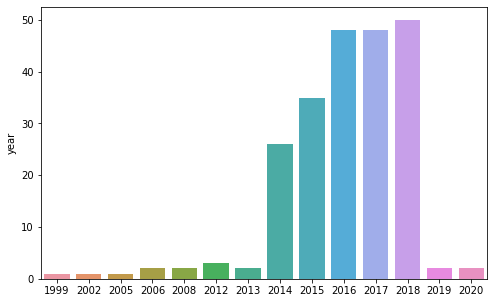

In [7]:
count_days = pd.DataFrame(df["opendate"].value_counts())
count_days.reset_index(inplace=True)
count_days.rename(columns={'index':'opendate', 'opendate':'count'}, inplace=True)
count_days['opendate'] = pd.to_datetime(count_days['opendate'])

# Distribution by year
count_days['year'] = count_days.opendate.dt.year
count_days['month'] = count_days.opendate.dt.month
count_days['weekday'] = count_days.opendate.dt.weekday_name
count_days['yearmonth'] = count_days.opendate.map(lambda x: 100*x.year + x.month)

#count_days["year"].value_counts().plot(kind='bar')
df_offers_by_year = pd.DataFrame(count_days['year'].value_counts())
sns.barplot(x=df_offers_by_year.index, y=df_offers_by_year.year, data=df_offers_by_year)
fig=plt.gcf()
fig.set_size_inches(8,5)
plt.show()

- Before 2014, very few employment opportunities were offered to the citizen. As we approach 2020, we can see that the number of bulletins is increasing, there's even already job postings for 2020. There is a strong issue in managing the turnover since 2014. The number of job opportunities offred has almost doubled between 2014 and 2016, and then the number of published bulletins remain high.
- This makes our job even more challenging !

#### 1.b.2 Job postings by month over the years

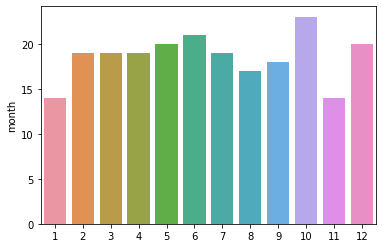

In [8]:
# Distribution by months
df_offers_by_month = pd.DataFrame(count_days['month'].value_counts())
ax = sns.barplot(x=df_offers_by_month.index, y=df_offers_by_month.month, data=df_offers_by_month)

- The job openings seem about the same over the years throughout the months. January and November seem the months when there are less job opennings; October on the other hand seems to be the month when most of job opennings occur.
- January and Novemeber are the months with less postings.
- October concentrates more postings than other months, maybe this can be explained by the fact that it is a "back to business" period, the city assesses what is needed in september after school holidays and posts in October.
- ______ Budget decisions may be taken in November as well which leads to concentrate lots of postings in October. ____

#### 1.b.3 Job postings by weekdays over the years

When are the job posted during the week ?

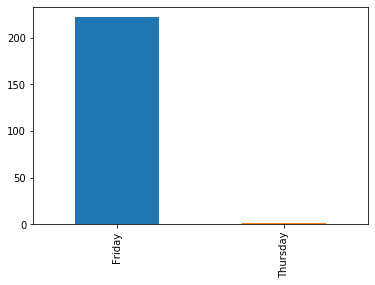

In [9]:
count_days["weekday"].value_counts().plot(kind='bar')

Apparently, almost every job openning is posted on a friday! Why is that, is it the best option ? It leaves candidates time to review them on weekends ?

#### 1.b.4 Number of requirements specified

In [10]:
df['nb_requirements'].describe()

count    675.000000
mean       1.924444
std        1.080682
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        9.000000
Name: nb_requirements, dtype: float64

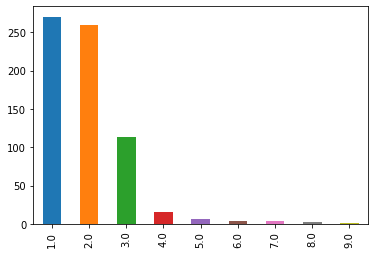

In [11]:
df['nb_requirements'].value_counts().plot(kind='bar')

The number of requirements can have a big impact and the more is indicated, the more female candidate can be discouraged, it may represent an unconscious bias. This parameter is to be looked up, because when confronted to a lot of requirements, A candidate can feel uncomfortable.
The number of requirements should be moderate to allow more candidates to apply.

##### Here:
- The large majority of the bulletins indicate less that 4 requirements.
- However there are few bulletins that include more than 4 requirements and up to 9 !

##### What we can infer :
- Including more than 3 requirements can add to much complexity in the reading of the job posting and can be due to the intend of having a dedicated candidate, which may constitute a bias.


#### 1.b.5 Number of steps to go through during the recruting process

Let's check the different steps, what are they, how many are required and in which proportion

In [12]:
df['selection'].value_counts()

[Interview]                     162
[Essay, Interview]              130
[]                               99
[Test]                           93
[Questionnaire]                  30
[Test, Interview]                29
[Essay]                          25
[Test, Essay, Interview]         22
[Review]                         10
[Questionnaire, Interview]       10
[Test, Test]                      9
[Test, Questionnaire]             8
[Experience]                      6
[Evaluation]                      5
[Choice, Essay, Interview]        5
[Exercise, Interview]             4
[Written, Interview]              4
[Essay, Test, Interview]          3
[Choice, Interview]               3
[Written]                         3
[Test, Essay]                     2
[Test, Test, Test]                2
[Essay, Test]                     2
[Essay, Exercise, Interview]      2
[Test, Exercises, Interview]      1
[Choice, Test]                    1
[Written, Essay, Interview]       1
[Test, Defense]             

* Several selection steps can be asked for one job (maximum 3). 

Let's get a list of distinct possible selection steps

In [13]:
flattened_list = [y for x in df['selection'].value_counts().index for y in x]

In [14]:
text=word_tokenize(' '.join(flattened_list))
no_order = list(set(text))
no_order

['Evaluation',
 'Exercises',
 'Abilities',
 'Interview',
 'Essay',
 'Experience',
 'Questionnaire',
 'Choice',
 'Written',
 'Exercise',
 'Test',
 'Defense',
 'Review']

* 13 types of evaluation are possible but some of them seem weird (Abilities, Review and Defense), we'll check them later

In [15]:
df['selection'].describe()

count             675
unique             31
top       [Interview]
freq              162
Name: selection, dtype: object

In [16]:
df['nb_selection_steps'].describe()

count    675.000000
mean       1.263704
std        0.771392
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: nb_selection_steps, dtype: float64

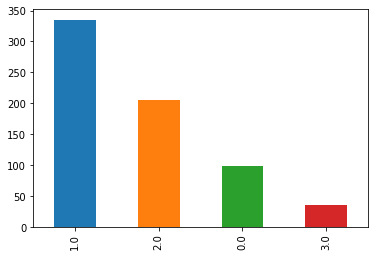

In [17]:
df['nb_selection_steps'].value_counts().plot(kind='bar')

Having a complex selection process may dissuade potential candidates, like disabled ones or women because of its duration and the availability required for attending each appointment. Enabling a complex selection process can be legitimate when the city wants to hire a high responsibility profile.

##### Here:
- There are up to 3 steps for the selection. 
- This procedure helps the collectivity ensure they are hiring the appropriate candidate.
- 80%  of the job opportunities include 1 or 2 steps, the most common being interview and tests.
- 15% of them do not require any selection step.
- The remaning 5% of bulletins suggest a selection performed in 3 steps. Are they related to a specific kind of job ?

##### Next steps:
By intituion, we would say that a 3-step selection process should be reserved to high responsibility position, where a hiring mistake can have strong impacts on the organzation.
We then need to look for a correlation between the number of selection steps and the responsibility level.

#### 1.b.6 Number of lines in the job description

In [18]:
df['nb_lines'].describe()

count     675
unique     63
top        83
freq       31
Name: nb_lines, dtype: int64

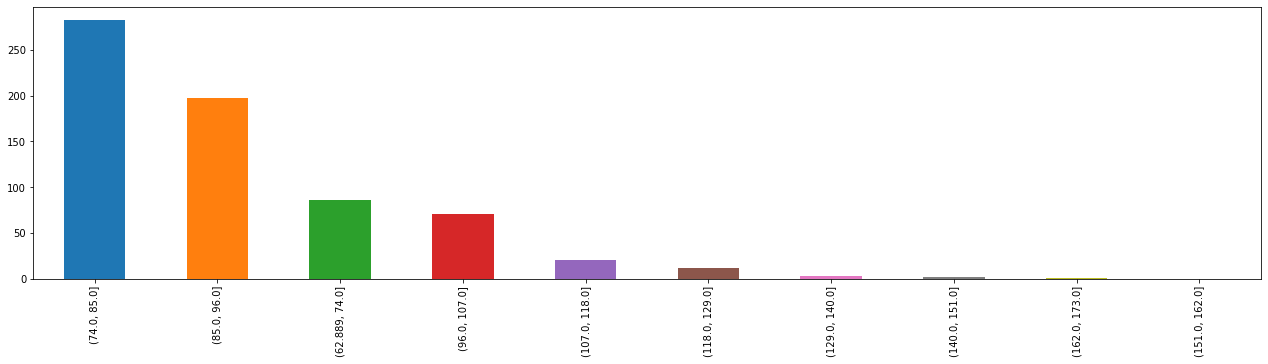

In [19]:
df['nb_lines'].value_counts(bins=10).plot(kind='bar', figsize=(22,5))

#### Analysis of the number of lines in the job description
Having a long description may be interesting for high responsibility positions in order to provide sufficient context elements on the job offer and the performance of the work. 
However a long bulletin can dissuade potential candidates to apply because the text would be too long.

##### Here:
- Most of the job postings include less than 100 lines.
- The vast majority is between 74 and 96 lines

##### Next steps:
We will list the positions according to a scale of responibility and check if a long job description is legitimato or not. if it is not the case, maybe is it due to an unconsious biais.
We will use a scale from 1 to 5

#### 1.b.7 Number of caracters in the job description

In [32]:
df['nb_chars'].describe()

count      675
unique     649
top       8215
freq         3
Name: nb_chars, dtype: int64

In [33]:
df['nb_chars'].value_counts(bins=5).head()

(7659.0, 10684.0]     339
(10684.0, 13709.0]    161
(4618.874, 7659.0]    133
(13709.0, 16734.0]     38
(16734.0, 19759.0]      4
Name: nb_chars, dtype: int64

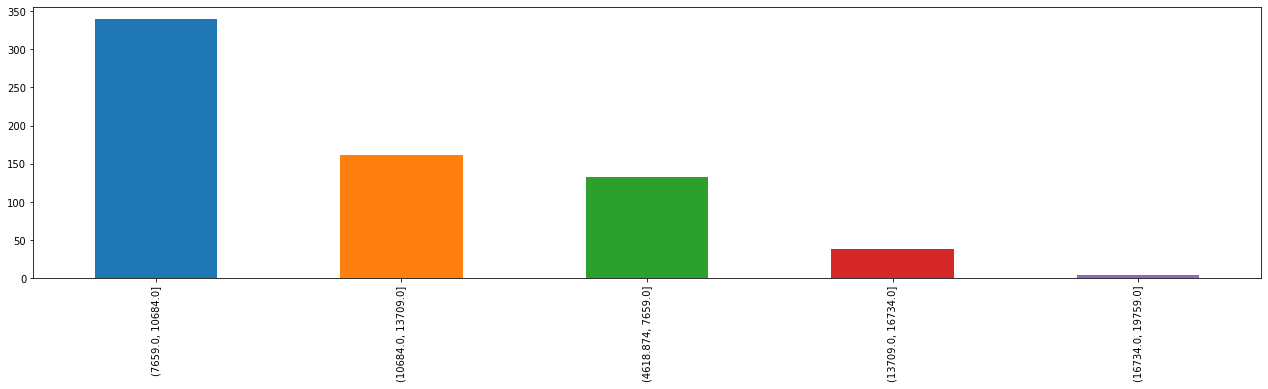

In [34]:
df['nb_chars'].value_counts(bins=5).plot(kind='bar', figsize=(22,5))

#### Analysis
Having a long description may be interesting for high responsibility positions in order to provide sufficient context elements on the job offer anr the performance of the work. 
However a charged (in terms of chars) can dissuade potential candidates to apply because the text would be too complex.

##### Here:
- Most of the job postings (527 of them i.e 78%) include 4.600 to 13.700 caracters.
- the remaining 148 bulletins (about 22%) may  be too 'verbose'.

##### Next steps:
We will list the positions according to a scale of responibility and check if a verbose description is legitimate or not. if it is not the case, maybe is it due to an unconsious biais.
We will use a scale from 1 to 5

#### 1.b.8 Deadline - Time to apply

validity_duration field has been computed to give us the time between the date the job was posted and the deadline to apply.

In [35]:
df['validity_duration'].describe()

count     625
unique     38
top        13
freq      494
Name: validity_duration, dtype: int64

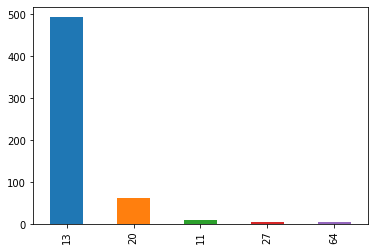

In [36]:
# Visualize To Pten validity_durations
df['validity_duration'].value_counts().head(5).plot(kind='bar')

#### Analysis of the time remaining to apply
Validity duration is an important parameter. Offering little time to apply reduces the number of candidates . We can expect a job opening to leave enough time to people to apply. Maybe more for disabled people who may have access to the job opennings less easily. We can also expect the deadline to  be extended for rare profiles like those intended for high responsibility positions.


If a low validity duration is given for a high responsibility position or for a position open to all, it can represent a barrier to the City to meet interesting external candidates. We should here offer a prescriptive action to the City.

##### Here
- Most of the job opportunities (about 65%) are to be applied within 13 days, equivalent to 2 weeks since the release of the bulletin.
- The next most common validity duration is 20 days equivalent to 3 weeks. 
- Up to 10 bulletins offer a validity duration of 10 days, which is rather short. This is the shortest validity duration.

##### Next steps:
We have to explore those bulletins with 11-day validity duration, check if they are opent to all and check if the position leads to high responibilities. We will foculs on 11-day validity bulletin because this is the shortest duration, and a 13-day validity duration is to common. 

## Descriptive Analysis Summary
#### File parsing performance
- Over the 683 files we managed to keep 675 of them after parsing (98%).

#### Offered employment
- Before 2014, very few employment opportunities were offered to the citizen. As we approch 2021, we can see that the number of bulletins is increasing. There is a strong issue in managing the turnover since 2014. The niumber of job opportunities offred is almost doubled between 2014 and 2016, and then the number of published bulletins remain high.
- This makes our job even more challenging !

#### Job posting all over the year
- It seems that about the same amount of jobs have been posted every month throughout the years.

#### Number of requirements
- In large majority,  the bulletins indicate less that 4 requirements.
- However thet are few bulletins that include more requirements even up to 9 !
- Including lots of requirements may have a negative impact on female applications and therefore be part of an unconscious bias. This parameter is to be looked into.

#### Number of selection steps
- There are up to 3 steps for the selection.
- This procedure helps the collectivity ensure they are hiring the appropriate candidate.
- 80%  of the job opportunities include 1 or 2 steps, the most common being interview, essay and test.
- 15% of them do not require a complex selection process.
- The remaning 5% of bulletins suggest a selection performed in 3 steps. Are they related to a specific kind of job ?
- Having a 3-step selection process may dissuade potential candidates, like disabled ones or women because of its duration and the availability required for attending each appointment.

#### Validity duration
- Most (about 65%) of the job opportunities are to be applied within 13 days equivalent to 2 weeks since publishing of the bulletin.
- The next validity duration is 20 days equivalent to 3 weeks. 
- Up to 10 bulletin offer a validity duration of 10 days, which is rather short. This is the shortest validity duration.
- Validity duration is an important parameter, offering little time to apply may reduce the number of candidates.
We also need to identify if some job positions are only opened to current employees, which can explain why validity duration is short.

#### Next steps
Correlate Responsibility level with :
- Validity duration, 
- Nb of requirements in the job description
- Nb steps in the selection process
- Nb lines in the job description
- Nb chars in the job description

### 1.d Feature engineering - Enriching the dataframe with computed fields

In this section we will enhance our dataframe with additional computed fields:
- nb_line_scale : number of lines on a scale from 0 to 5
- nb_char_scale : number of chars on a scale from 0 to 5
- full_time_part_time_code : indicates if job is part time (1) or full time (2)
- exp_years : number of years of experience needed
- high_education : 1 if requiring University or College, 0 else
- Open_To_All : indicates if the position is open to all including actual city employees
- Resp_level : scale of responsibility from 0 to 5

Resp_level based on the job title : 
- Director = 5, 
- Manager, Principal, Chief, Captain  = 4, 
- Engineer, Specialist, Representative, Advocate, Inspector, Supervisor = 3
- Officer = 2
- Other = 0

In [37]:
df['Position'].describe()

count                675
unique               665
top       annual salary 
freq                   3
Name: Position, dtype: object

In [38]:
# Calculates the number of lines on a scale from 0 to 5
def ScaleNBLine(line_nb):
    results = 0
    if line_nb < 60:
        return(0)
    elif line_nb < 85:
        return(1)
    elif line_nb < 110:
        return(2)
    elif line_nb < 130:
        return(3)
    elif line_nb < 150:
        return(4)
    else:
        return(5)

# Calculates the number of lines on a scale from 0 to 5
def ScaleNBChar(line_nb):
    results = 0
    if line_nb < 7000:
        return(0)
    elif line_nb < 11000:
        return(1)
    elif line_nb < 110:
        return(2)
    elif line_nb < 13000:
        return(3)
    elif line_nb < 160000:
        return(4)
    else:
        return(5)

# Calculates responsibility level for each position
def RespLevel(position):
    results = 0
    if "DIRECTOR" in position.upper():
        return(5)
    
    elif "MANAGER" in position.upper():
        return(4)
    elif "PRINCIPAL" in position.upper():
        return(4)
    elif "CHIEF" in position.upper():
        return(4)
    elif "CAPTAIN" in position.upper():
        return(4)
    
    elif "ENGINEER" in position.upper():
        return(3)
    elif "SPECIALIST" in position.upper():
        return(3)
    elif "ADVOCATE" in position.upper():
        return(3)
    elif "REPRESENTATIVE" in position.upper():
        return(3)
    elif "INSPECTOR" in position.upper():
        return(3)    
    elif "SUPERVISOR" in position.upper():
        return(3)
    elif "SUPERINTENDENT" in position.upper():
        return(3)
    
    elif "OFFICER" in position.upper():
        return(2)
    elif "LIEUTENANT" in position.upper():
        return(2)
    return(0)

# Identifies if a position is open to all
def open2all(raw_text):
    if "exam open to current" in raw_text.lower():
        return 0
    return 1
    # If Nothing is mentionned on whether external candidates can apply
    # It shall mean that the job offer is opened to all
    
# Identifies if ther is a mention "Exam open to..."
def mention_Exam_Open(raw_text):
    if "exam open" in raw_text.lower():
        return 1
    return 0

    
# Tests if  we ha a NaN recording in a cell of the dataframe
def isNaN(num):
    return num != num

# Translates the experience requierement into a number
def get_nb(val):
    if not isNaN(val):
        if val.lower() == 'one':
            return 1
        if val.lower() == 'two':
            return 2
        if val.lower() == 'three':
            return 3
        if val.lower() == 'four':
            return 4
        if val.lower() == 'five':
            return 5
        if val.lower() == 'six':
            return 6
        if val.lower() == 'seven':
            return 7
        if val.lower() == 'eight':
            return 8
        if val.lower() == 'nine':
            return 9
        if val.lower() == 'ten':
            return 10
        else:
            print(val)
            return np.nan

# Calculates if there is a requirement on the backgourd College or University formulated in the bulletin
def code_school(val):
    if not isNaN(val):
        if val == "College or University":
            return 1 
        
    #better for correlations (at list one variation)
    return 0
        

# Calcultates if the position allaow part time or full time
def code_ft_pt(val):
    if not isNaN(val):
        if val == "PART_TIME":
            return 1
        if val == "FULL_TIME":
            return 2
        
    #better for correlations (at list one variation)
    return 0

In [39]:
df_enriched = df.copy()
df_enriched['nb_line_scale'] = df_enriched['nb_lines'].apply(lambda x : ScaleNBLine(x))
df_enriched['nb_char_scale'] = df_enriched['nb_chars'].apply(lambda x : ScaleNBChar(x))
df_enriched['Resp_level'] = df_enriched['Position'].apply(lambda x : RespLevel(x))
df_enriched['Open_To_All'] = df_enriched['raw_job_text'].apply(lambda x : open2all(x))
df_enriched['Open_To_Mention'] = df_enriched['raw_job_text'].apply(lambda x : mention_Exam_Open(x))
df_enriched['exp_years'] = df_enriched['EXPERIENCE_LENGTH'].apply(lambda x : get_nb(x))
df_enriched['high_education'] = df_enriched['SCHOOL_TYPE'].apply(lambda x : code_school(x) )
df_enriched['full_time_part_time_code'] = df_enriched['FULL_TIME_PART_TIME'].apply(lambda x : code_ft_pt(x))



In [40]:
df_enriched.head()

,File Name,Position,salary_start,salary_end,opendate,requirements,duties,deadline,deadline_date,validity_duration,...,EDUCATION_YEARS,SCHOOL_TYPE,nb_line_scale,nb_char_scale,Resp_level,Open_To_All,Open_To_Mention,exp_years,high_education,full_time_part_time_code
0,311 DIRECTOR 9206 041814.txt,311 director,"125,175","$155,514",2014-04-18,1. One year of full-time paid experience as a ...,A 311 Director is responsible for the successf...,"MAY 1, 2014",2014-05-01,13,...,NaN,NaN,1,1,5,1,0,1.0,0,2
1,ACCOUNTANT 1513 062218.txt,accountant,"49,903","$72,996",2018-06-22,Graduation from an accredited four-year colleg...,An Accountant does professional accounting wor...,"AUGUST 25, 2018",2018-08-25,64,...,four,College or University,2,1,0,1,1,NaN,1,0
2,ACCOUNTING CLERK 1223 071318.txt,accounting clerk,"49,005","$71,618",2018-07-13,Two years of full-time paid office clerical ex...,An Accounting Clerk performs difficult and res...,NaN,NaT,NaN,...,NaN,NaN,2,1,0,1,1,2.0,0,2
3,ACCOUNTING RECORDS SUPERVISOR 1119 072718.txt,accounting records supervisor,"55,332","$80,930",2018-07-27,Two years of full-time paid experience as an A...,"An Accounting Records Supervisor assigns, revi...","AUGUST 9, 2018",2018-08-09,13,...,NaN,NaN,2,1,3,0,1,2.0,0,2
4,ADMINISTRATIVE ANALYST 1590 060118.txt,administrative analyst,"60,489","$88,468",2018-06-01,1. One year of full-time paid professional exp...,An Administrative Analyst performs professiona...,"JUNE 14, 2018",2018-06-14,13,...,four,College or University,2,3,0,0,1,1.0,1,2


In [41]:
df_enriched['Resp_level'].describe()

count    675.000000
mean       1.795556
std        1.748160
min        0.000000
25%        0.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: Resp_level, dtype: float64

In [42]:
df_enriched['Resp_level'].value_counts().head(10)

0    313
3    215
4     99
5     25
2     23
Name: Resp_level, dtype: int64

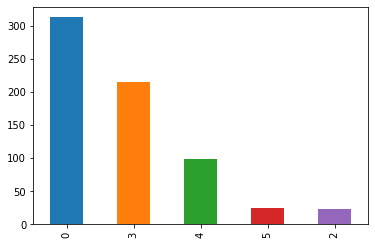

In [43]:
df_enriched['Resp_level'].value_counts().head(10).plot(kind='bar')

#### 1.d.1 Responsibility Level
- Most (about 50%) of the job opportunities are very low responsibility levels (levels 0 to 2)
- About 46% of the job positions present a medium or high responibility level (level 3 and 4). 
- About 4% of the job positions deal with very high responsibility (level 5)

Our feeling is that the should not have displayed biais especially for medium to very high responsibility levels. If there is a bias, for instance en gender bias, it should be considered as a critical one.

In [44]:
df_enriched['Open_To_All'].describe()

count    675.000000
mean       0.548148
std        0.498045
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Open_To_All, dtype: float64

In [45]:
df_enriched['Open_To_All'].value_counts()

1    370
0    305
Name: Open_To_All, dtype: int64

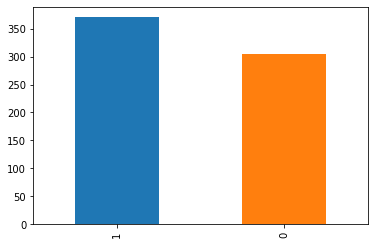

In [46]:
df_enriched['Open_To_All'].value_counts().head().plot(kind='bar')

#### 1.d.2 Open to All
- About 370 Job bulletins (about 55%) are open to all kind of candidates including already city employees.
  - About 305 Job bulletins (about 50%) clearly specify the are open to all.
  - About 35 Job bulletins (about 5%) do not specify whether the job is opent to external cadidates.
- About 305 Job bulletins (about 45%) are only open to current city employees

This is huge, only 50% of the job postings are open to every candidate, this may reduce chances to have new candidates.

In [47]:
df_enriched['full_time_part_time_code'].value_counts()

2    576
0     99
Name: full_time_part_time_code, dtype: int64

#### 1.d.3 Part time or full time ?
- The very large most of the position are specifically indicated as open in Full time (about 85%)
- The remaining bulletins (99 of them) DO NOT specify if they are open to PART_TIME or NOT. Wee assume that they are fulltime.


In [48]:
df_enriched['high_education'].value_counts()

0    553
1    122
Name: high_education, dtype: int64

#### 1.d.4 High eductation or Not ?
- Only 122 job position require a college or university education (about 18%)
- The remaining bulletins DO NOT specify anything. We will assume that they do don't require it.


## 2. Gender bias analysis

Let's assign a "tendency" to each job posting based on the following paper :
https://www.hw.ac.uk/services/docs/gendered-wording-in-job-ads.pdf

Are there any indication of a gender bias in the duties part ?

In [49]:
df_enriched['GENDER_WORDS'] = df['duties'].apply(lambda x : assess.assess(x)['result'])

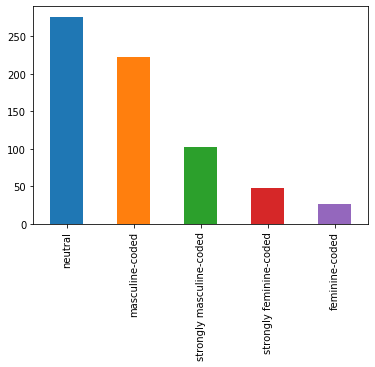

In [50]:
df_enriched["GENDER_WORDS"].value_counts().plot(kind='bar')

In [51]:
df_enriched["GENDER_WORDS"].value_counts()

neutral                     276
masculine-coded             222
strongly masculine-coded    102
strongly feminine-coded      48
feminine-coded               27
Name: GENDER_WORDS, dtype: int64

#### 2.a Gender tendency analysis
There is an insight here !

- 41% of the bulletins are masculine coded including 
* 33% are masculine coded
* 8% are strongly masculine coded
- Only 11 % are feminine or strongly feminine coded 

So the job postings are three times more inclined towards masculine words than feminine.

#### Next steps: 
- We need to enrich the dataset with the tendancy separetedly masculine or feminine

In [52]:
def tooMasculine(raw_text):
    if "masculine" in raw_text.lower():
        return((1))
    else:
        return(0)

def tooFeminine(raw_text):
    if "feminine" in raw_text.lower():
        return((1))
    else:
        return(0)

def code_gender_bias(val):
    if not isNaN(val):
        if val == "neutral":
            return 0
        if val == 'masculine-coded':
            return 1
        if val == 'strongly masculine-coded':
            return 2
        if val == 'feminine-coded':
            return 3
        if val == 'strongly feminine-coded':
            return 4
        else:
            return np.nan

def code_gender_score(val):
    if not isNaN(val):
        if val == "neutral":
            return 0
        if val == 'masculine-coded':
            return 1
        if val == 'strongly masculine-coded':
            return 4
        if val == 'feminine-coded':
            return 1
        if val == 'strongly feminine-coded':
            return 4
        else:
            return 0

In [53]:
df_enriched['Too_Feminine'] = df_enriched['GENDER_WORDS'].apply(lambda x : tooFeminine(x))
df_enriched['Too_Masculine'] = df_enriched['GENDER_WORDS'].apply(lambda x : tooMasculine(x))
df_enriched['gender_bias'] = df_enriched['GENDER_WORDS'].apply(lambda x : code_gender_bias(x))
df_enriched['gender_score'] = df_enriched['GENDER_WORDS'].apply(lambda x : code_gender_score(x))

In [54]:
df_enriched.head()

,File Name,Position,salary_start,salary_end,opendate,requirements,duties,deadline,deadline_date,validity_duration,...,Open_To_All,Open_To_Mention,exp_years,high_education,full_time_part_time_code,GENDER_WORDS,Too_Feminine,Too_Masculine,gender_bias,gender_score
0,311 DIRECTOR 9206 041814.txt,311 director,"125,175","$155,514",2014-04-18,1. One year of full-time paid experience as a ...,A 311 Director is responsible for the successf...,"MAY 1, 2014",2014-05-01,13,...,1,0,1.0,0,2,neutral,0,0,0,0
1,ACCOUNTANT 1513 062218.txt,accountant,"49,903","$72,996",2018-06-22,Graduation from an accredited four-year colleg...,An Accountant does professional accounting wor...,"AUGUST 25, 2018",2018-08-25,64,...,1,1,NaN,1,0,strongly masculine-coded,0,1,2,4
2,ACCOUNTING CLERK 1223 071318.txt,accounting clerk,"49,005","$71,618",2018-07-13,Two years of full-time paid office clerical ex...,An Accounting Clerk performs difficult and res...,NaN,NaT,NaN,...,1,1,2.0,0,2,neutral,0,0,0,0
3,ACCOUNTING RECORDS SUPERVISOR 1119 072718.txt,accounting records supervisor,"55,332","$80,930",2018-07-27,Two years of full-time paid experience as an A...,"An Accounting Records Supervisor assigns, revi...","AUGUST 9, 2018",2018-08-09,13,...,0,1,2.0,0,2,neutral,0,0,0,0
4,ADMINISTRATIVE ANALYST 1590 060118.txt,administrative analyst,"60,489","$88,468",2018-06-01,1. One year of full-time paid professional exp...,An Administrative Analyst performs professiona...,"JUNE 14, 2018",2018-06-14,13,...,0,1,1.0,1,2,strongly masculine-coded,0,1,2,4


The enriching with the gender tendency is over

## 4. What are the bulletins that require immediate action to reduce unconscious biases ?
For this, we will look for bulletins with high masculine or high feminine coded language and check their responsibility level as well as the complexity of the selection, and the validity duration 


#### 4.a Interesting correlations
In this section, we will check if there are 'unlegitimate' correlation between 
- responisibility level, 
- vadility duration
- nb_lines_scale (in the text description)
- Nb_chars_scale
- nb_requirement
- nb_selection steps, 
- Open_to_All
- exp_years
- full_time_part_time_code
- high_education
- toomasculine
- toofeminine

In [55]:
df_correlation = df_enriched.drop(columns=["opendate", "requirements","duties", "deadline", "deadline_date","selection","Essay","Interview","WTest","FULL_TIME_PART_TIME", "EDUCATION_YEARS", "SCHOOL_TYPE", "raw_job_text", "EXPERIENCE_LENGTH", "Open_To_Mention"], axis=1)
#df_correlation.drop(columns=["opendate", "requirements","duties", "deadline", "deadline_date", "Interview","WTest","FULL_TIME_PART_TIME", "EDUCATION_YEARS", "SCHOOL_TYPE", "GENDER_WORDS"], axis=1)
df_correlation.head()

,File Name,Position,salary_start,salary_end,validity_duration,nb_lines,nb_chars,nb_requirements,nb_selection_steps,nb_line_scale,...,Resp_level,Open_To_All,exp_years,high_education,full_time_part_time_code,GENDER_WORDS,Too_Feminine,Too_Masculine,gender_bias,gender_score
0,311 DIRECTOR 9206 041814.txt,311 director,"125,175","$155,514",13,72,9781,3.0,1.0,1,...,5,1,1.0,0,2,neutral,0,0,0,0
1,ACCOUNTANT 1513 062218.txt,accountant,"49,903","$72,996",64,90,10260,1.0,2.0,2,...,0,1,NaN,1,0,strongly masculine-coded,0,1,2,4
2,ACCOUNTING CLERK 1223 071318.txt,accounting clerk,"49,005","$71,618",NaN,88,10291,1.0,1.0,2,...,0,1,2.0,0,2,neutral,0,0,0,0
3,ACCOUNTING RECORDS SUPERVISOR 1119 072718.txt,accounting records supervisor,"55,332","$80,930",13,87,7821,1.0,2.0,2,...,3,0,2.0,0,2,neutral,0,0,0,0
4,ADMINISTRATIVE ANALYST 1590 060118.txt,administrative analyst,"60,489","$88,468",13,93,11451,3.0,3.0,2,...,0,0,1.0,1,2,strongly masculine-coded,0,1,2,4


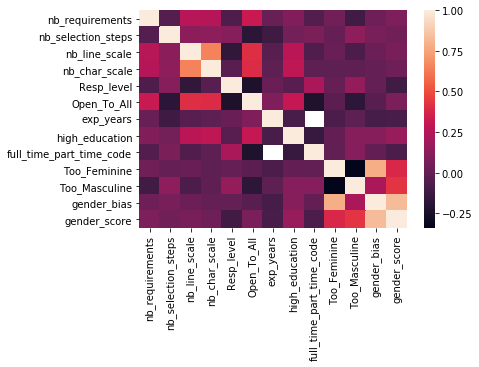

In [56]:
import seaborn as sns
corr = df_correlation.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

#### 4.b Interesting correlations summary

##### Open_To_All VS nb_requirements 
> No straight correlation ==> Difficult to suspect a biais on this situation

##### high_education VS Open_To_All 
> No straight correlation ==> Difficult to suspect a biais on this situation

##### Resp_level VS tooMasculine and tooFeminine : 
> There is very little (0.25) trend that responsibility level can correlate with masculine coded. 
> The opposite trend is obtained for feminine coded (-0.25)

##### Resp_Level  VS nb_line_scale
> At the opposite to what we could expect there is not a strait correlation between the nuber of lines in the job description and the responsibility level.

##### Resp_Level VS nb_char_scale
> At the opposite to what we could expect there is not a straight correlation between the nuber of chars in the job description and the responsibility level.

##### Resp_Level VS nb_char_scale
> At the opposite to what we could expect there is not a straight correlation between the nuber of chars in the job description and the responsibility level.

##### Resp_Level VS nb_selection_steps
> There is very little (0.25) trend that responsibility level can correlate with the number of selection steps which makes sense. 

##### Resp_Level VS nb_requirements
> No straight correlation ==> Difficult to suspect a biais on this situation.

##### Resp_Level VS : other observations
> There is also 1 little correlation betweel Resp_Level and Fulltime job. Indeed, Responibility jobs require full time.
> We can also be surprised by the fact that there is no straigh correlation between Resp_Level and exp_years, neither high_education. The backgroung does not seem to be important for offering rresponsibility jobs.

##### Too_Masculine VS ???
> There is a little trend on the correlation of TooMasculine with the number of requirements, the complexity of the selection, the requirement of a high education background.
> The sexist trend is very subtle.

##### Too_Feminine VS ???
> there is no straight correlation possible between a feminine coded bulletin and other bulletin characteristics.


#### 4.c Suspicious bulletins

We need to identify the most suspicious bulletins inside our dataframe of 675. By "suspicious", we mean buletins that would be biased, or that would need to follow basic recommandations about the validity duration, or other parameters.

For this, we are going to score bulletin. The score is a combiations of penalties based on the main indcators of a biais which are 
- Resp_level
- gender_score
- nb_line_scale
- nb_char_scale
- nb_selection_steps
- nb_requirements
- Open_To_All
- validity_duration

The higher the socre is, the higher is the necessity to look up the bulletin. 
> When it comes to medium to high responnsibility position, biased bulletins are sanctioned even harder.



In [58]:
def code_gender_score(val):
    if not isNaN(val):
        if val == "neutral":
            return 0
        if val == 'masculine-coded':
            return 1
        if val == 'strongly masculine-coded':
            return 4
        if val == 'feminine-coded':
            return 1
        if val == 'strongly feminine-coded':
            return 4
        else:
            return 0

def bulletin_score(row, dataframe):
    
    #resp, gender_score,nblines,nbchars,opentoall,nbreq,nbsel,valid, educ
    score = 0
    
    if dataframe["Resp_level"][row] < 3:
            if dataframe["nb_line_scale"][row] > 3:
                # + 1 penalty when too many lines
                score += 1
            
            if dataframe["nb_char_scale"][row] > 3:
                # + 1 penalty when too many chars
                score += 1
            
            if dataframe["high_education"][row] ==1:
                # + 2 penalty when high education required for low resposnsibility
                score +=2
            
            if dataframe["nb_requirements"][row] == 4:
                score += 1
                # + 1 penalty when 4 requirements
                
            if dataframe["nb_requirements"][row] >5:
                # + 4 penalty when too many requirements
                score +=4
            
            if dataframe["nb_selection_steps"][row] == 2:
                # + 1 penalty when 2 selection steps
                score += 1
            if dataframe["nb_selection_steps"][row] > 2:
                # + 1 penalty when 3 selection steps
                score +=4
                
            if dataframe["Open_To_All"][row]==1:
                if dataframe["validity_duration"][row] <=12:
                    # + 4 when little time given to apply whereas position open to all
                    score +=4
            score += 1
            score*= dataframe["gender_score"][row]
            score *= dataframe["Resp_level"][row]
            
                    
    else:
        # if position with responsibility, more penalty is given to gender trend
        if dataframe["Open_To_All"][row]==1:
            if dataframe["validity_duration"][row] <=12:
                # + 4 when little time given to apply whereas position open to all
                score +=4
        if dataframe["gender_score"][row] >0:
            score += 5
            score *= dataframe["gender_score"][row]
            score *= dataframe["Resp_level"][row]
    
    return(score)
            
       

In [59]:
df_scored = df_correlation
#df_scored['score'][row] = df_scored.apply(lambda row : code_gender_score(row))
df_scored.insert(loc=3, column='score', value=0, allow_duplicates = False)
for row in range(0, len(df_scored)):
    df_scored['score'][row] = bulletin_score(row,df_correlation)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [60]:
df_scored.head()


,File Name,Position,salary_start,score,salary_end,validity_duration,nb_lines,nb_chars,nb_requirements,nb_selection_steps,...,Resp_level,Open_To_All,exp_years,high_education,full_time_part_time_code,GENDER_WORDS,Too_Feminine,Too_Masculine,gender_bias,gender_score
0,311 DIRECTOR 9206 041814.txt,311 director,"125,175",0,"$155,514",13,72,9781,3.0,1.0,...,5,1,1.0,0,2,neutral,0,0,0,0
1,ACCOUNTANT 1513 062218.txt,accountant,"49,903",0,"$72,996",64,90,10260,1.0,2.0,...,0,1,NaN,1,0,strongly masculine-coded,0,1,2,4
2,ACCOUNTING CLERK 1223 071318.txt,accounting clerk,"49,005",0,"$71,618",NaN,88,10291,1.0,1.0,...,0,1,2.0,0,2,neutral,0,0,0,0
3,ACCOUNTING RECORDS SUPERVISOR 1119 072718.txt,accounting records supervisor,"55,332",0,"$80,930",13,87,7821,1.0,2.0,...,3,0,2.0,0,2,neutral,0,0,0,0
4,ADMINISTRATIVE ANALYST 1590 060118.txt,administrative analyst,"60,489",0,"$88,468",13,93,11451,3.0,3.0,...,0,0,1.0,1,2,strongly masculine-coded,0,1,2,4


In [61]:
df_sorted = df_scored
df_sorted.sort_values(by=['score'], inplace=True, ascending=False)
df_sorted.head(10)

,File Name,Position,salary_start,score,salary_end,validity_duration,nb_lines,nb_chars,nb_requirements,nb_selection_steps,...,Resp_level,Open_To_All,exp_years,high_education,full_time_part_time_code,GENDER_WORDS,Too_Feminine,Too_Masculine,gender_bias,gender_score
145,COMMUNICATIONS INFORMATION REPRESENTATIVE 1461...,communications information representative,"41,697",108,"$59,340",11,111,13006,3.0,2.0,...,3,1,1.0,0,2,strongly feminine-coded,1,0,4,4
617,TRANSPORTATION ENGINEERING ASSOCIATE 7280 0724...,transportation engineering associate,"68,549",108,"$85,149",11,88,12544,2.0,1.0,...,3,1,NaN,1,0,strongly masculine-coded,0,1,2,4
163,CUSTOMER SERVICE REPRESENTATIVE 1230 020918.txt,customer service representative,"57,148",108,"$71,012",11,89,9186,1.0,2.0,...,3,1,2.0,0,2,strongly feminine-coded,1,0,4,4
195,ELECTRICAL ENGINEERING ASSOCIATE 7525 093016 R...,electrical engineering associate,"66,231",108,"$94,252",11,94,11977,3.0,1.0,...,3,1,NaN,0,0,strongly masculine-coded,0,1,2,4
55,ASSISTANT DIRECTOR INFORMATION SYSTEMS 9377 03...,assistant director information systems,"145,199",100,"$180,382",13,77,8157,1.0,2.0,...,5,0,2.0,0,2,strongly feminine-coded,1,0,4,4
172,DIRECTOR OF AIRPORT OPERATIONS 9304 062317 (3)...,director of airport operations,"141,858",100,"$201,867",13,80,9286,3.0,1.0,...,5,1,4.0,0,2,strongly masculine-coded,0,1,2,4
181,DIRECTOR OF PRINTING SERVICES 1488 101218 REV ...,director of printing services,"117,596",100,"$171,946",20,74,8078,2.0,1.0,...,5,0,3.0,0,2,strongly masculine-coded,0,1,2,4
113,CHIEF FORENSIC CHEMIST 2237 092818.txt,chief forensic chemist,"106,362",80,"$155,493",13,77,6419,2.0,1.0,...,4,1,1.0,0,2,strongly masculine-coded,0,1,2,4
120,CHIEF OF OPERATIONS 7258 042018 REV 051318.txt,chief of operations,"90,473",80,"$132,274",20,103,14062,2.0,2.0,...,4,1,3.0,0,2,strongly masculine-coded,0,1,2,4
119,CHIEF OF DRAFTING OPERATIONS 7271 042018.txt,chief of drafting operations,"135,302",80,"$168,084",13,80,8166,1.0,2.0,...,4,0,3.0,0,2,strongly feminine-coded,1,0,4,4


#### 4.c Top 10 Suspicious bulletins scoring analysis

In this top 10:
> 40% are of the bulletins are strongly feminine coded
> 60% are strongly masculine coded.
> All of them are medium to high responibility positions which make sense, as our schme add more penalites to thos profiles.
> The highest scores are given to 11-days validity duration bulletins open to all, which can be considered as too short to allow external candidates to apply


Revolting habits: the score also unviels that the city is very traditionalist and tends to follow stereotypes likes 
> Jobs for women consists in secretary, communication or sales.
> Jobs for men  consists in more technical jobs such as engineers.


# 5. Modeling

We managed to get a dataset with the number of applicants to each position and their characteristics (gender and race). Let's check our work on the gender scoring.

In [1]:
ds_applications = pd.read_csv('./Job_Applicants_by_Gender_and_Ethnicity.csv')

NameError: name 'pd' is not defined

In [ ]:
ds_applications['JobNumber'] = ds_applications['Job Number'].apply(lambda val:str(val).split()[0])
ds_applications.head()

In [ ]:
def get_job_number(val):
    JobNumber = re.compile('\D\d+') # match job number
    jn = re.search(JobNumber, val)
    return jn.group().lstrip()

df_scored['JobNumber'] = df_scored['File Name'].apply(lambda val : get_job_number(str(val)))

In [ ]:
df_merged_lab = pd.merge(df_scored, ds_applications, on=['JobNumber'])
df_merged_lab.head(2)

In [ ]:
df_merged_lab.columns

# Let's remove race informations as we won't have tiem to go into it
df_merged_lab.drop(columns=['Unknown_Gender', 'Black', 'Hispanic', 'Asian','Caucasian', 'American Indian/ Alaskan Native', 'Filipino','Unknown_Ethnicity'], inplace=True)

#### 5.2 Simple encoding of target result based on what we know

Let's code a target label based on the number of male/female applicants.
First, simple : if more male applicants, let's code it as to_male = 1

In [ ]:
def get_tendency(rowF, rowM):
    if rowF > 0:
        if rowM/rowF > 1:
            return 1
        
    return 0

df_merged_lab['ratio'] = df_merged_lab['Female'] /  df_merged_lab['Male']
df_merged_lab['to_male'] = df_merged_lab['ratio'].apply(lambda x: 1 if x < 1 else 0)
df_merged_lab.head()

In [ ]:
df_merged_lab.drop(columns=['File Name', 'Position', 'Fiscal Year', 'Job Number', 'Job Description', 'Apps Received', 'ratio'], inplace=True)
df_merged_lab.drop(columns=['GENDER_WORDS','Too_Feminine', 'Too_Masculine', 'gender_bias', 'gender_score','JobNumber', 'Female', 'Male'], inplace=True)
df_merged_lab.drop(columns=['salary_start', 'score', 'salary_end'], inplace=True)

In [ ]:
df_merged_lab.dropna(inplace=True)
df_merged_lab.columns

### 5.3 Training and testing 

Let's get our train and test datasets from the labeled one

In [ ]:
# importing necessary libraries 
from sklearn import datasets 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 

# X -> features, y -> label 
X = df_merged_lab.drop(['to_male'], axis=1)
y = df_merged_lab['to_male']
  
# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

#### 5.3.1 First model : Decision Tree